# Simulation-Based Inference for Structural Estimation

Simulation based inference is a technique to perform maximum likelihood and Bayesian estimation without needing a likelihood function. This tutorial is designed to accompany my [paper](https://cameronfen.github.io/publication/simulation/), which contains more in-depth explanations of the methods being used and their effectiveness.

Before I illustrate how to do Sequential Neural posterior Estimation (SNPE) and related other simulation-based estimation (SBI) techniques, I hope to convince you that SNPE is generally better than baseline economic methods for Bayesian, MLE, and simulation-based estimation.  

Here is a graph illustrating the posterior of SNPE, compared to benchmark Metropolis-Hasting Markov Chain Monte Carlo (MCMC). This is 4 marginal distributions of the posterior, each illustrating a somewhat different type of fit:

![](https://drive.google.com/uc?export=view&id=19QaIOwG1ICMNDmbCH0rz0z_32gIFAxmh)

The performance of other SNPE posteriors compared to MCMC is similar to the marginals in this picture and can be found in the results section of the paper. The red line indicates the true data generating parameter and the blue line is the posterior distribution. X axis represents the support of the prior/posterior for the variable in question and the y axis indicates probability mass.  

The approach also has advantages over other simulation-based methods by being efficient when well specified and having a Bayesian extensions. Likewise, as a Bayesian algorithm it has advantages over MCMC and [SMC estimation](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.2397), by being a simulation approach which doesn't require a likelihood and can handle models that are black boxes that only provide simulated data conditional on a set of parameters.  

Now to describe the method: In Bayesian inference, we are after the posterior: $P(\theta|X)$. This can be decomposed into: $P(\theta|X) = \dfrac{P(X|\theta)P(\theta)}{P(X)}$. In this case, SNPE assumes one can only sample from the likelihood, $P(X|\theta)$, not calculate its value.  The algorithm works by sampling from the joint distribution of the likelihood (i.e. simulating from the model conditional on a prior parameter draw) and the prior. Then the algorithm uses a machine learning conditional density estimator to produce the distribution of the parameters conditional on the simulated data $P(\theta|X)$.  Conditioning the simulated data variable on the actual data produces the posterior $P(\theta|X=X')$, where $X'$ is the data from the true data-generating process.  The paper and the [slides](https://cameronfen.github.io/files/SNPE_Presentation.pptx) produce a more intuitive and detailed explanation of the method.   

First, I will discuss how to estimate macro models using [SNPE](https://arxiv.org/abs/1905.07488). Then I will discuss some extensions to vanilla SNPE that might be useful for economists. You can find a large set of jupyter notebook tutorials on SBI and SNPE [here](https://github.com/mackelab/sbi/tree/main/tutorials). However, if you want a more econ focused tutorial, I've written this notebook.

## SNPE

First, I will install the SBI package and dependents which are needed:

In [ ]:
!pip install sbi

Now we need to import the necessary libraries to perform SNPE. I have added a seed in `numpy` and in `PyTorch`, feel free to change the seed to test code robustness.  

In [ ]:
import torch
import numpy as np
from numpy import genfromtxt
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time

from sbi import utils as utils
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.inference.base import infer
import sbi
from sbi import analysis

import autograd.numpy as np
from autograd import jacobian

torch.manual_seed(1)
np.random.seed(1)

Now I will introduce the black box simulator.  SNPE works by sampling from the prior and then sampling from the likelihood simulator conditional on your prior.  The likelihood simulator is just a fancy word for the macro (or other structural) model you want to estimate. In normal MCMC, you would be using the model to calculate the likelihood of your data. In SNPE, it's assumed that you can't evaluate model likelihood, you can only simulate from the model (likelihood). SNPE can handle any black box taking model that outputs simulated values generated from the input parameters.

I will use an RBC model as my simulator. There are three sets of variables in this function: contemporaneous which has no subscript; lagged variables: L subscript; and one period ahead variables: P subscript.  The code contains a set of nonlinear equations that determine the dynamics of the system.  

The first equation in the RBC model is a somewhat rearranged Euler equation: $\beta r_p\dfrac{c^{\gamma}}{c_p^{\gamma}} - 1$

The second equation is the marginal product of capital: $\alpha z k_l^{\alpha-1}+(1-\delta) - r$

The third equation is the GDP accounting identity: $(1-\delta)k_l + y - c - k$

The fourth equation is the production function: $z k_l^\alpha - y$

The fifth equation is the low of motion for productivity: $\rho log(z_l) + \epsilon - log(z)$

Here is the code that sets up the RBC model as well as some default parameters:


In [ ]:
# Indexing
nX = 5
nEps = 1
iZ, iR, iK, iY, iC = range(nX)


# Parameters
alpha = 0.4
beta = 0.98
gamma = 2.0
delta = 0.02
rho = 0.95
sigma = .01

def varF(X_Lag,X,X_Prime,epsilon, al, be, de, rh):

    # Unpack
    Z, R, K, Y, C = X
    Z_L, R_L, K_L, Y_L, C_L = X_Lag
    Z_P, R_P, K_P, Y_P, C_P = X_Prime


    return np.hstack((
            be * R_P * C_P**(-gamma) * C**gamma - 1.0, # Euler equation
            al * Z  * K_L **(al-1) + 1 -de - R, # MPK
            (1-de) * K_L + Y - C - K,# Aggregate resource constraint
            Z * K_L**al - Y,# Production function
            rh * np.log(Z_L) + epsilon - np.log(Z)# TFP evolution
            ))

In order to solve this model, I will follow Alisdair McKay's [tutorial](https://alisdairmckay.com/Notes/HetAgents/RBC) using [time iteration](https://irihs.ihs.ac.at/id/eprint/4351/1/es-330.pdf) to solve the RBC model. The linear model has the form:
\begin{equation}
AE_tX_{t+1} + BX_t + CX_{t-1}+E\epsilon_t = 0 \tag{1}
\end{equation}

The way to calculate $A$, $B$, $C$, $E$ is to recognize that this is a linear approximation.  So to get the first order equations, all you need is take the first derivative of the nonlinear system of equations with respect to the correct variables ($X_{t+1}$, $X_t$, $X_{t-1}$ and $\epsilon$) evaluated at the steady state.  The below code calculates the matrices:


In [ ]:
def VarSteadyState(al, be, de, rh):
    nX = 5
    Z = 1.
    R = 1/be
    K = ((R-1+de)/al)**(1./(al-1))
    Y = K**al
    C = Y - de*K

    X = np.zeros(nX)
    X[[0,1,2,3,4]] = (Z, R, K, Y, C)
    return X

vnum = np.array([.6,.95,.1,.9])
a, b, d, r = alpha, beta, delta, rho
iterations = 100

X_SS = VarSteadyState(a, b, d, r)
epsilon_SS = 0.0
# Linearize
A = jacobian(lambda x: varF(X_SS,X_SS,x,epsilon_SS, a, b, d, r))(X_SS)
B = jacobian(lambda x: varF(X_SS,x,X_SS,epsilon_SS, a, b, d, r))(X_SS)
C = jacobian(lambda x: varF(x,X_SS,X_SS,epsilon_SS, a, b, d, r))(X_SS)
E = jacobian(lambda x: varF(X_SS,X_SS,X_SS,x, a, b, d, r))(epsilon_SS)

Now since your method is a linear method: $X_t = PX_{t-1} + Q\epsilon_t$.  You can plug in $X_t$ into equation 1.  With some algebra you get a fixed-point equation for $P$ and once you know $P$ you can solve for $Q$.  I only briefly touch upon this because it doesn't matter what solution method you use, any black box is that can simulate data can work with SNPE. I chose time iteration. However, perturbation, projection, value function iteration, Reiter's method, sequence-space Jacobian, and Winberry's method all will work fine. If you have questions about the solution method, I encourage you to go to Alisdair McKay's [write-up](https://alisdairmckay.com/Notes/HetAgents/RBC) on estimating an RBC model.

Below is the algorithm that takes in $A$, $B$, $C$ and $E$ and solves the fixed-point algorithm:

In [ ]:
def SolveSystem(A,B,C,E,P0=None):
    # Solve the system using linear time iteration as in Rendahl (2017)
    #print("Solving the system")
    MAXIT = 1000
    if P0 is None:
        P = np.zeros(A.shape)
    else:
        P = P0

    S = np.zeros(A.shape)

    for it in range(MAXIT):
        P = -np.linalg.lstsq(B+A@P,C,rcond=None)[0]
        S = -np.linalg.lstsq(B+C@S,A,rcond=None)[0]
        test = np.max(np.abs(C+B@P+A@P@P))
        # if it % 20 == 0:
        #     print(test)
        if test < 1e-7:
            break


    if it == MAXIT-1:
        raise ValueError('Did not converge')#warnings.warn('LTI did not converge.')


    # test Blanchard-Kahn conditions
    if np.max(np.linalg.eig(P)[0])  >1:
        raise RuntimeError("Model does not satisfy BK conditions -- non-existence")

    if np.max(np.linalg.eig(S)[0]) >1:
        raise RuntimeError("Model does not satisfy BK conditions -- mulitple stable solutions")

    # Impact matrix
    #  Solution is x_{t}=P*x_{t-1}+Q*eps_t
    Q = -np.linalg.inv(B+A@P) @ E

    return P, Q


The entire system solving the RBC model is illustrated here.  This function will play the role of the black box simulator.



In [ ]:
def solve_and_sim(vectorin):
    #solve
    vnum = vectorin.numpy().reshape((-1))
    a, b, d, r = vnum[0], vnum[1], vnum[2], vnum[3]
    iterations = 100
    try:

        X_SS = VarSteadyState(a, b, d, r)
        epsilon_SS = 0.0
        # Linearize
        A = jacobian(lambda x: varF(X_SS,X_SS,x,epsilon_SS, a, b, d, r))(X_SS)
        B = jacobian(lambda x: varF(X_SS,x,X_SS,epsilon_SS, a, b, d, r))(X_SS)
        C = jacobian(lambda x: varF(x,X_SS,X_SS,epsilon_SS, a, b, d, r))(X_SS)
        E = jacobian(lambda x: varF(X_SS,X_SS,X_SS,x, a, b, d, r))(epsilon_SS)
        P, Q = SolveSystem(A,B,C,E)


        #simulate

        xvec = np.zeros((iterations + 1,nX))

        noise = .01*np.random.randn((iterations))
        for idx in range(iterations):
            xvec[1 + idx,:] = P@xvec[idx,:] + Q * noise[idx]
        xvec = xvec[1:,:].reshape((1,5*iterations))
    except:
        xvec = np.empty((1,5*iterations))
        xvec.fill(np.nan)

    return torch.tensor(xvec, dtype = torch.float32)

Note that the code takes in a vector of parameters `vecin` and outputs a vector of simulated data. The input is a `PyTorch` vector, and the output must also be a `PyTorch` vector.  This simulated data should have the same structure as the real data one is trying to match and one should include a `try`/`except` loop in case the simulator doesn't converge, which sometimes happens in structural models. In that case, you should output a list of Nan so SNPE knows to ignore that simulation.  

The input parameters are $\alpha$: capital's share of production; $\beta$: discount rate; $\delta$: depreciation rate; and $\rho$: autoregressive term on productivity's law of motion.  

Now for the actual SNPE algorithm. In my experience, the libraries available for SNPE make it easier to implement than many of the other algorithms mentioned. I hope this tutorial illustrates the ease of use. Most of the hyperparameters are tuned for you, and basic estimation is as simple as writing 50-60 lines of relatively boilerplate code.  

First, I will load the data. The data is in my [macrosbi repo](https://github.com/CameronFen/macrosbi), which is unmaintained, but contains something like a master function to run many different types of SBI as well.  This is real macro data from FRED. You can look at the csv file by just visiting the url.

In [ ]:
rawurl = 'https://raw.githubusercontent.com/CameronFen/macrosbi/main/krbc.csv'

num_rounds = 10

writer = SummaryWriter()

datax = genfromtxt(rawurl,delimiter=',')

datax = datax.reshape(100,5)

tdata = torch.tensor(datax.ravel().reshape(1,-1), dtype = torch.float32)

Next, I will define the prior.  I use uniform prior with the range 0 to 1 for ease of use.  You can use any `pytorch` distribution object as long as it has a `.sample()` and a `.log_prob`.  For more information on how to construct your own `pytorch` distributions (or borrow from a library of distributions) see [here](https://pytorch.org/docs/stable/distributions.html#).  You additionally prepare the prior and simulator with `prepare_for_sbi`.  

In [ ]:
prior_min = [0.,0.,0.,0.]
prior_max = [1.,1.,1.,1.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min),
                                    high=torch.as_tensor(prior_max))

simulator, prior = prepare_for_sbi(solve_and_sim, prior)

As mentioned in the black box function, the order of variables is:

```
def solve_and_sim(vectorin):
    vnum = vectorin.numpy().reshape((-1))
    a, b, d, r = vnum[0], vnum[1], vnum[2], vnum[3]
```

The birds-eye view of this function is that this approach allows you to sample from the joint/unnormalized posterior: $\theta,X \sim P(X|\theta)P(\theta)$ and then you use a conditional density estimator to calculate the conditional distribution $P(\theta|X)$ from the sampled data. SNPE uses a mixture of Gaussians or a normalizing flow to do this conditional density estimation. See the paper for more details on how these density estimators work. Then when you have the conditional density estimator you condition on the true data, $X'$, to give the posterior for $\theta$: $P(\theta|X=X')$.

Initializing the main inference code is one line:


In [ ]:
inference = SNPE(prior=prior, summary_writer=writer, device='cpu', density_estimator='maf')

The important variable is `density_estimator = `  You can put `"nsf", "maf", "mdn", "made"`.  I wouldn't use the `"mdn"` density estimators as it's prone to errors, however in my presentation, it is the easiest density estimator to explain which is why I discuss it in some detail in my presentation.  

I don't find it that useful to use a GPU to speed up the inference (ie fitting the density estimator).  95% of compute is used in simulating data, speeding up the last 5% training the density estimator is not all that helpful.  It certainly is helpful to use multithreading or GPUs when simulating the model, for example, 1 million times.   

I use `maf` which is a masked autoregressive flow density estimator. I will discuss how to use a custom normalizing flow further below (and also visit the SBI tutorial [page](https://github.com/mackelab/sbi/blob/main/tutorials/05_embedding_net.ipynb)). In anticipation for multi-round inference, `posteriors`, `sampsvec`, `sampsstd`, `xsamp`, and `theatasamp` are all vectors with each element corresponding to the sample round.  For the purposes of estimation, I used 5000 simulations. Notice how I set `num_workers` to 2. Often that's as complicated as you need to get to do multithreading.  Potentially, even for this model, but certainly for more complex models, one would need more than 5000 simulations.  

In [ ]:
posteriors = []

proposal = prior


sampsvec = []
sampsstd = []
xsamp = []
thetasamp = []

theta1, x1 = simulate_for_sbi(solve_and_sim, proposal, num_simulations=5000, num_workers=2)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

As mentioned, I am appending samples to the initiated lists. The way SNPE works is that if you have generated $x$ and $\theta$ samples it will train on them.  However, with multi-round samples, SNPE will keep samples from past rounds and train the density estimator on all the samples you have generated in the past, while importance sampling to adjust for distribution shift. This is why you simulate with `simulate_for_sbi` and after each round of simulation, you add the simulation to the entire database of simulations with `inference.append_simulations()`.  

Additionally, if your model does not converge for a subset of samples, and your simulator generates `nans`, I wrote some code to remove `nan` samples. Often SBI is smart enough to ignore `nan`'s, but occasionally something will trip it up, so it's just smart to remove them before appending them into the simulation.  


In [ ]:
xsamp.append(x1)
thetasamp.append(theta1)


filterindx = ~torch.any(x1.isnan(),dim=1)
x = x1[filterindx]
theta = theta1[filterindx]


density_estimator = inference.append_simulations(theta, x, proposal=prior).train(training_batch_size=50)

posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)
proposal = posterior.set_default_x(tdata)

 Neural network successfully converged after 28 epochs.

Line 10 trains the density estimator, then you build your conditional density estimator and condition the density estimator on your real data `tdata`. You have $P(\theta|X)$, now you need to condition $X$ on $X'$ the real data. This is your posterior.  Of course, if you want to engage in multi-round inference, you will sample from this proposal posterior, instead of the prior, importance sample, and repeat the exercise, as I will discuss next.  

There are too few samples to get full convergence to the posterior, however the true data generating process values are $\alpha = .4, \beta = .98, \delta = .02, \rho = .95$. This is the order of the variables as they appear in the analysis.  I include a running mean and standard deviation of all the parameters for each round of the model.  

But take a second and congratulate yourself.  You have completed your first SNPE Bayesian posterior estimation. Multi-round simulation is not much more complex. The point of multi round inference is to get a more accurate posterior. You sample your parameters from the best guess of your posterior instead of from the prior.  This means your parameter samples are more relevant to your actual posterior. Then you use importance sampling to adjust for the divergence from the prior distribution.  The only thing to add for multi-round simulation is to add a for loop and make sure you set your proposal for `simulate_for_sbi` to the posterior obtained in the previous round.  

If you are using a different seed, there could be problems with overfitting on limited data.  The SNPE algorithm will sometimes run into errors after fitting a model to data. This is because the tutorial runs 5000 samples each round which is less than the 10k+ samples per round often needed to avoid overfitting from some of the density estimators. If you want to rerun to make sure the errors don't reoccur, just simply rerun the `inference = SNPE(...` line back to here.  Also it might be useful to change the seed again.  

In [ ]:
num_rounds = 2

for r in range(num_rounds):
    theta1, x1 = simulate_for_sbi(solve_and_sim, proposal, num_simulations=5000, num_workers=2)
    xsamp.append(x1)
    thetasamp.append(theta1)

    # if r > 0:
    meanvec = posteriors[-1].sample((1000,), x = tdata).mean(0)
    stdvec = posteriors[-1].sample((1000,), x = tdata).std(0)
    print(meanvec)
    print(stdvec)
    sampsvec.append(meanvec)
    sampsstd.append(stdvec)

    filterindx = ~torch.any(x1.isnan(),dim=1)
    x = x1[filterindx]
    theta = theta1[filterindx]

    filterindx = ~torch.any(x.isinf(),dim=1)
    x = x[filterindx]
    theta = theta[filterindx]

    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(training_batch_size=1000)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(tdata)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.4708, 0.5154, 0.5304, 0.9423])
tensor([0.2297, 0.2301, 0.2277, 0.0397])
Using SNPE-C with atomic loss
 Neural network successfully converged after 68 epochs.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.2962, 0.7484, 0.4676, 0.9837])
tensor([0.1875, 0.1513, 0.2743, 0.0127])
Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.

Ifyou run the code with my seed (1) (at least when I run my code with seed 1) you will notice that the subsequent rounds lead to improving identification of the posterior based on the reported mean and std of the samples that are printed.  The true values are ($\alpha = .4,\beta = .98,\delta = .02,\rho = .95$).  One caveat that you have probably realized is that 15000 samples is too few to get optimal identification of the posteriors.  

After 50000 to 100000 iterations, the model would converge. In my results section I used  one million samples, which is overkill, but sampling from the RBC model is fast, so even that didn't take long.  Despite the RBC model being considered toy, it poses some challenges. 1. estimating four parameters is around (but somewhat lower) the number of parameters people are estimating in a Bayesian fashion for real papers. 2. One reason RBC models aren't considered fully formed models is that the parameters often have difficulty being identified, which provides challenges for a Bayesian method. Even so, it might take 30 mins to an hour to run enough iterations to identify RBC models, which is much faster than a python-native Metropolis-Hastings MCMC algorithm would take.  

Next we will graph the results to see the posterior performance:

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

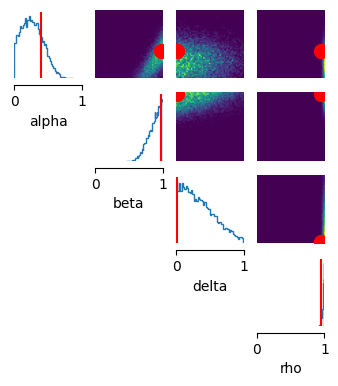

In [ ]:
postsamps = posteriors[-1].sample((10000,), x = tdata)
labels = ['alpha', 'beta', 'delta', 'rho']
lim = [[0,1],[0,1],[0,1],[0,1]]
truedata = np.array([.4,.98,.02,.95])

fig, ax = analysis.pairplot(postsamps,
                          points=truedata,
                          labels=labels,
                          limits=lim,
                          ticks=lim,
                          points_colors='r',
                          figsize=[4., 4.])

As you can see from the graph, after 15000 iterations, you are starting to get posteriors that look reasonable.  The modes are close to the true values and they seem to be coalscing after rounds of iterations. This is not the converged posterior, but even after 15k iterations, we are closing in.

## Extensions
### Matlab Simuator

Dynare and MATLAB are popular for structural macroeconomic estimation.  I will show how to use a MATLAB/Dynare function as the simulator in my python code.  First, follow [these](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html) directions to set up the MATLAB engine for python. If you use Dynare, make sure to wrap it with a MATLAB master function. Either way write a master MATLAB function that takes in parameters and outputs simulated data.  I recommend doing parallel processing in MATLAB if possible, however speedups still work multiprocessing on the python end.  Finally, when you have written your master MATLAB file, make sure to add to the MATLAB path the location of the master file. In this example, just to clarify, the MATLAB function being called in python is `krusell_smith` and `vec1` is the input into the function.  Since this function will not run in colab, I'm just including the code in the text cell:

```
def dynarefunct(vecin):
  try:
    eng = matlab.engine.start_matlab()
    vec = vecin.reshape(-1).numpy().tolist() #remember vecin is a pytorch tensor
    vec1 = matlab.double(vec, size = (8,1))
    x = np.asarray(eng.krusell_smith(vec1).reshape(1,2596))
  except:
    x = np.empty((1,2596))
    x.fill(np.nan)
  return torch.tensor(x, dtype = torch.float32)
```

In the case of this code, there was no place to parallel process the code in MATLAB, so I will have to multithread in the sampling step with `simulat_for_sbi` (change number of workers as you would with any other estimation). Since threads are called one at a time, each time you call `dynarefunct` you need to restart the MATLAB engine: `eng = matlab.engine.start_matlab`.  One advantage of multithreading in MATLAB is you can call `eng` outside of the `dynarefunct` itself which is why I recommend multithreading in matlab rather than python.  

### Normalizing Flow Density Estimator

Currently I've shown you how to use a default normalizing flow as a conditional density estimator. However, I will show you how to write a customized density estimator.  

A normalizing flow is a sequence of changes of variables, that allows you to transform an easy-to-use distribution, like the multivariate normal, into arbitrary 'nonparametric' distributions of choice.  For more information feel free to look at my [paper](https://cameronfen.github.io/publication/simulation/) or [here](https://blog.evjang.com/2018/01/nf1.html)

This is how to code it up. Here is a basic PyTorch feed forward neural network that I will use as an embedding that reduces the dimensionality of the `X'` data into something more manageable. This embedding is trained end-to-end with the posterior density estimation loss function, this means that if there is a low dimension sufficient statistic, which there will likely be if a small number of parameters produced your `X` data, the neural network will be able to learn it. The intuition here is a Rao-Blackwell argument where the sufficient statistic will maximize the information to minimize the density estimator loss, so the embedding will learn the mapping between `X'` and the sufficient statistic.  This enables the conditional distribution to maximize the likelihood of the parameters. This is an improvement on [Ahn et al.](https://sehyoun.com/static/phact_new.pdf), where one reduces dimensionality with PCA--a function that cannot be trained.  I show the results of a HANK model that does just this below.  Here is the code for the embedding:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SummaryNetFeedForward(nn.Module):

    def __init__(self, timesteps, covariates, hiddendim = 128, embeddingdim = 20):
        super().__init__()
        self.ts =timesteps
        self.cov = covariates
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(in_features=covariates*timesteps, out_features= hiddendim)
        self.fc2 = nn.Linear(in_features=hiddendim, out_features=hiddendim)
        self.fc3 = nn.Linear(in_features=hiddendim, out_features=embeddingdim)
        self.relu = nn.ReLU()

    def forward(self,x):
        x= x.reshape(-1,self.ts,self.cov)
        hn = self.flatten(x) #reshaping the data for Dense layer next
        out = self.fc1(hn) #first Dense
        out = self.relu(out) #relu
        out = self.fc2(out) #Final Output
        out = self.relu(out)
        out = self.fc3(out)

        return out

Now we combine this neural network with an autoregressive flow:

In [ ]:
embedding_net = SummaryNetFeedForward(5,100)

neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=4
)

One thing to note is that the `SummaryNetFeedForward` has inputs--covariates of `X` by timesteps of `X`. In practice all that matters is the product of these two as the whole data set is flattened. Then you run the inference code:

In [ ]:
inference = SNPE(prior=prior, density_estimator=neural_posterior)

Now you can run the simulation code which is exactly the same code as before:

In [ ]:
posteriors = []

proposal = prior


sampsvec = []
sampsstd = []
xsamp = []
thetasamp = []

theta1, x1 = simulate_for_sbi(solve_and_sim, proposal, num_simulations=1000, num_workers=2)

xsamp.append(x1)
thetasamp.append(theta1)


filterindx = ~torch.any(x1.isnan(),dim=1)
x = x1[filterindx]
theta = theta1[filterindx]


density_estimator = inference.append_simulations(theta, x, proposal=prior).train(training_batch_size=50)

posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)
proposal = posterior.set_default_x(tdata)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 51 epochs.

I'll let you combine this with multi-round inference yourself.  

### Results and Other Techniques
Here are some other results, for even more results see my [paper](https://cameronfen.github.io/publication/simulation/). All my applications use flat priors, to best illustrate the algorithm's ability to converge even to unidentified posteriors.  To extend the results in my introduction, here are the marginal distribution of the first 12 parameters in the 36 parameter Smets Wouters 2007 model after five hundred thousand iterations:

![](https://drive.google.com/uc?export=view&id=1iiVceaDWr8T2ERYiP7j0RDbG6bEIimDA)

There is a bit of an issue with histogram smoothing.  The results would look better if the posterior was smoothed, but this picture illustrates the natural continuity that these machine learning conditional estimators produce even without kernel smoothing.  Likewise, here is the MCMC after ten million iterations:

![](https://drive.google.com/uc?export=view&id=1olyBa6K3OrAQfx0RytrLo6Dq6XdVbL8V)

Additionally, here is a posterior for a HANK model solved via Reiter. Traditionally likelihood techniques run into trouble, as the state space is 500-1500 variables large.  Thus, the main way to perform likelihood evaluation, which requires filtering, is to perform dimensionality reduction on the state space, by for example [PCA](https://www.nber.org/papers/w23494). My simulation-based approach sidesteps filtering, and so can be estimated without any approximations:

![](https://drive.google.com/uc?export=view&id=1P_yrCd9Lg4THD5jPXWlxoh8Rq6YcIEbP)

Likewise, I estimate a model solved by [Winberry](https://onlinelibrary.wiley.com/doi/full/10.3982/QE740) extending the full information approach estimated on [simulated data](https://onlinelibrary.wiley.com/doi/full/10.3982/QE1810) to using my method to estimate the [Krusell Smith (1998)](http://www.econ.yale.edu/smith/250034.pdf) model on both empirical macro and micro data. The macro data comes from FRED and other standard sources like the Department of Labor, while the micro data (wealth) comes from the Survey of Income and Program Participants. For the micro data, I match percentiles of SIPP data, with wealth percentiles in the model.  This is natural to do from a simulation-based inference perspective via simulation, but very difficult to do via a likelihood method as one would have to calculate the order statistic for each percentile.  

![](https://drive.google.com/uc?export=view&id=15ncp0389lbyCaqA3px5HowYYhHfdlsBg)

I hope these results and the tutorial convince you that SNPE is easy to use and effective. I won't go into detail with other techniques. If you are interested in SNVI, another inference technique that uses GANs and variational inference, you can find code to implement that estimation technique [here](https://github.com/mackelab/sbi/blob/main/tutorials/17_vi_posteriors.ipynb). If you want to create graphs of this data, SBI's API describes that [here](https://www.mackelab.org/sbi/tutorial/07_conditional_distributions/). I hope this was helpful. Feel free to email me at camfen (at) umich (dot) edu.  
